In [ ]:
!pip install --upgrade jupyter ipywidgets
import os
os.environ["HF_HUB_DISABLE_SYMLINKS_WARNING"] = "1"



In [ ]:
import os
os.environ['TORCH_USE_CUDA_DSA'] = '1'

# Verify that the environment variable is set
print(f"TORCH_USE_CUDA_DSA: {os.getenv('TORCH_USE_CUDA_DSA')}")


TORCH_USE_CUDA_DSA: 1


In [ ]:
!nvidia-smi


Thu Jan 30 18:19:49 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 561.17                 Driver Version: 561.17         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4090      WDDM  |   00000000:01:00.0  On |                  Off |
| 34%   55C    P2            248W /  598W |   11626MiB /  24564MiB |     58%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
from transformers import AutoModelForVideoClassification
import torch.nn as nn
import torch

# Define number of classes
num_classes = 8  # Ensure this matches your dataset
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize VideoMAE model
model = AutoModelForVideoClassification.from_pretrained("MCG-NJU/videomae-base")
model.classifier = nn.Linear(model.config.hidden_size, num_classes)  # Update classifier for downstream task

# Move model to GPU
try:
    model = model.to(device)
    print("Model successfully moved to GPU!")
except Exception as e:
    print(f"Error moving model to GPU: {e}")

# Debugging function for input data and target
def debug_data(data, target):
    print(f"Input Data Shape: {data.shape}")
    print(f"Target Shape: {target.shape}, Target Min: {target.min()}, Target Max: {target.max()}")

    # Ensure labels are valid
    if target.dtype != torch.long:
        print(f"Converting target dtype from {target.dtype} to torch.long")
        target = target.long()

    assert target.min() >= 0 and target.max() < num_classes, (
        f"Invalid labels! Expected range [0, {num_classes - 1}], "
        f"but got min={target.min()}, max={target.max()}"
    )
    return data, target

# Debug first batch
for data, target in train_loader:
    data, target = debug_data(data, target)
    break


Some weights of VideoMAEForVideoClassification were not initialized from the model checkpoint at MCG-NJU/videomae-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model successfully moved to GPU!
Input Data Shape: torch.Size([16, 16, 3, 224, 224])
Target Shape: torch.Size([16]), Target Min: 0, Target Max: 7


In [ ]:
import torch
torch.cuda.memory_stats()  # Debug memory status
torch.cuda.ipc_collect()   # Release cached memory
torch.cuda.empty_cache()   # Clear unused memory


In [ ]:
def load_dataset(directory):
    data = []
    for category in os.listdir(directory):
        class_path = os.path.join(directory, category)
        for video_folder in os.listdir(class_path):
            video_path = os.path.join(class_path, video_folder)
            data.append((video_path, category))  # Make sure this tuple is being created
            print(f"Added ({video_path}, {category})")  # Debug print
    return data
train_data = load_dataset('C:/Users/T2420318/Dataset/output_dataset (1)/train')
test_data = load_dataset('C:/Users/T2420318/Dataset/output_dataset (1)/test')

# Print some sample data to verify
print("Sample training data:", train_data[:5])
print("Sample testing data:", test_data[:5])


Added (C:/Users/T2420318/Dataset/output_dataset (1)/train\Abuse\Abuse001_x264, Abuse)
Added (C:/Users/T2420318/Dataset/output_dataset (1)/train\Abuse\Abuse003_x264, Abuse)
Added (C:/Users/T2420318/Dataset/output_dataset (1)/train\Abuse\Abuse004_x264, Abuse)
Added (C:/Users/T2420318/Dataset/output_dataset (1)/train\Abuse\Abuse005_x264, Abuse)
Added (C:/Users/T2420318/Dataset/output_dataset (1)/train\Abuse\Abuse006_x264, Abuse)
Added (C:/Users/T2420318/Dataset/output_dataset (1)/train\Abuse\Abuse007_x264, Abuse)
Added (C:/Users/T2420318/Dataset/output_dataset (1)/train\Abuse\Abuse008_x264, Abuse)
Added (C:/Users/T2420318/Dataset/output_dataset (1)/train\Abuse\Abuse010_x264, Abuse)
Added (C:/Users/T2420318/Dataset/output_dataset (1)/train\Abuse\Abuse011_x264, Abuse)
Added (C:/Users/T2420318/Dataset/output_dataset (1)/train\Abuse\Abuse013_x264, Abuse)
Added (C:/Users/T2420318/Dataset/output_dataset (1)/train\Abuse\Abuse015_x264, Abuse)
Added (C:/Users/T2420318/Dataset/output_dataset (1)/tr

In [ ]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

class VideoDataset(Dataset):
    def __init__(self, data_dir, class_to_idx, num_frames, transform=None):
        self.data = []
        self.class_to_idx = class_to_idx
        self.num_frames = num_frames
        self.transform = transform
        self.idx_to_class = {v: k for k, v in class_to_idx.items()}

        # Populate data list with video paths and categories
        for category in os.listdir(data_dir):
            category_path = os.path.join(data_dir, category)
            if os.path.isdir(category_path):
                for video_file in os.listdir(category_path):
                    video_path = os.path.join(category_path, video_file)
                    self.data.append((video_path, category))

    def __getitem__(self, idx):
        video_path, category = self.data[idx]
        label = self.class_to_idx[category]

        # Dummy implementation for frame loading
        frames = torch.randn(self.num_frames, 3, 224, 224)

        if self.transform:
            frames = self.transform(frames)

        return frames, label

    def __len__(self):
        return len(self.data)

# Rest of your code remains the same
class_to_idx = {'Abuse': 0, 'Arrest': 1, 'Assault': 2, 'Fighting': 3,
                'Explosion': 4, 'Burglary': 5, 'Arson': 6, 'Normal': 7}

num_frames = 16
train_dir = 'C:/Users/T2420318/Dataset/output_dataset (1)/train'
test_dir = 'C:/Users/T2420318/Dataset/output_dataset (1)/test'



train_dataset = VideoDataset(train_dir, class_to_idx, num_frames)
test_dataset = VideoDataset(test_dir, class_to_idx, num_frames)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of testing samples: {len(test_dataset)}")

Number of training samples: 149
Number of testing samples: 54


In [ ]:
try:
    first_train_sample = train_dataset[0]
    frames, label = first_train_sample
    print("\nFirst training sample:")
    print(f" - Frames shape: {frames.shape}")
    print(f" - Label: {label} ({train_dataset.idx_to_class[label]})")
except Exception as e:
    print(f"An error occurred: {e}")


First training sample:
 - Frames shape: torch.Size([16, 3, 224, 224])
 - Label: 0 (Abuse)


In [ ]:
# Print the dataset size
import torch
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of testing samples: {len(test_dataset)}")

# Test the first item in the train dataset
first_train_sample = train_dataset[0]  # Access the first sample
frames, label = first_train_sample

print("\nFirst training sample:")
print(f" - Frames shape: {frames.shape}")  # Should be [num_frames, channels, height, width]
print(f" - Label: {label} ({train_dataset.idx_to_class[label]})")  # Print label and its corresponding class

# Check the DataLoader
for i, (data, targets) in enumerate(train_loader):
    print("\nBatch from DataLoader:")
    print(f" - Batch frames shape: {data.shape}")  # [batch_size, num_frames, channels, height, width]
    print(f" - Batch targets: {targets}")
    break  # Print only the first batch


Number of training samples: 149
Number of testing samples: 54

First training sample:
 - Frames shape: torch.Size([16, 3, 224, 224])
 - Label: 0 (Abuse)

Batch from DataLoader:
 - Batch frames shape: torch.Size([16, 16, 3, 224, 224])
 - Batch targets: tensor([7, 1, 0, 4, 0, 3, 7, 7, 3, 4, 7, 6, 1, 7, 7, 3])


In [ ]:
# if torch.isnan(loss) or torch.isinf(loss):
#     print(f"Invalid Loss Value: {loss}")
# else:
#     scaler.scale(loss).backward()


In [ ]:
import torch
import torch.nn as nn
from transformers import AutoModelForVideoClassification, AutoConfig

def initialize_model(num_classes):
    """Initialize the model with specific configuration"""
    try:
        # Load configuration with explicit image size parameters
        config = AutoConfig.from_pretrained(
            "MCG-NJU/videomae-base",
            num_labels=num_classes,
            torch_dtype=torch.float32,
            output_hidden_states=False,
            output_attentions=False,
            image_size=224,  # Add explicit image size
            num_frames=16,   # Add number of frames
            patch_size=16    # Add patch size
        )

        print("Model configuration loaded successfully")

        # Create model with configuration
        model = AutoModelForVideoClassification.from_config(config)

        # Modify classifier
        hidden_size = config.hidden_size
        model.classifier = nn.Sequential(
            nn.LayerNorm(hidden_size),
            nn.Dropout(0.1),
            nn.Linear(hidden_size, num_classes)
        )

        # Load pretrained weights with strict=False
        pretrained = AutoModelForVideoClassification.from_pretrained(
            "MCG-NJU/videomae-base",
            config=config,
            ignore_mismatched_sizes=True,
            torch_dtype=torch.float32  # Explicitly set dtype
        )

        # Copy pretrained weights except classifier
        pretrained_dict = pretrained.state_dict()
        model_dict = model.state_dict()
        pretrained_dict = {k: v for k, v in pretrained_dict.items()
                          if k in model_dict and 'classifier' not in k}
        model_dict.update(pretrained_dict)
        model.load_state_dict(model_dict, strict=False)

        print("Pretrained weights loaded successfully")

        return model

    except Exception as e:
        print(f"Error in model initialization: {e}")
        torch.cuda.empty_cache()
        raise

def verify_model_inputs(model, device):
    """Verify model inputs with dummy data"""
    model.eval()
    with torch.no_grad():
        # Create dummy input (batch_size, num_frames, channels, height, width)
        dummy_input = torch.randn(1, 16, 3, 224, 224).to(device)
        try:
            _ = model(dummy_input)
            print("Model input verification successful")
        except Exception as e:
            print(f"Model input verification failed: {e}")
            raise

def main():
    try:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Initialize model
        NUM_CLASSES = 8
        model = initialize_model(NUM_CLASSES)

        # Move model to device
        model = model.to(device)

        # Verify model inputs
        verify_model_inputs(model, device)

        print(f"Model successfully initialized and moved to {device}")

    except Exception as e:
        print(f"Error in main execution: {e}")
        torch.cuda.empty_cache()
        raise

if __name__ == "__main__":
    main()

Model configuration loaded successfully


Some weights of VideoMAEForVideoClassification were not initialized from the model checkpoint at MCG-NJU/videomae-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Pretrained weights loaded successfully
Model input verification successful
Model successfully initialized and moved to cuda


In [ ]:
from collections import Counter

# Count class distribution
label_counts = Counter(target for _, target in train_loader.dataset)
print("Class Distribution:", label_counts)


Class Distribution: Counter({7: 40, 0: 23, 2: 19, 4: 19, 1: 17, 3: 17, 5: 8, 6: 6})


In [ ]:
import torch
from tqdm import tqdm
from torch.optim.lr_scheduler import CosineAnnealingLR

def train(model, train_loader, test_loader, device, epochs=15):
    """
    Train the VideoMAE model with loss, accuracy tracking, and a progress bar.

    Args:
    - model: Pretrained VideoMAE model.
    - train_loader: DataLoader for training data.
    - test_loader: DataLoader for testing data.
    - device: Device (cuda or cpu).
    - epochs: Number of training epochs.

    Returns:
    - Lists of train & test losses and accuracies per epoch.
    """

    # ✅ Initialize optimizer, loss function, and scheduler
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)  # Reduced LR
    scheduler = CosineAnnealingLR(optimizer, T_max=epochs, eta_min=1e-6)
    loss_fn = torch.nn.CrossEntropyLoss()

    # ✅ Lists to store metrics
    train_losses, train_accuracies = [], []
    test_losses, test_accuracies = [], []

    best_test_acc = 0
    patience = 5
    patience_counter = 0  # ✅ Fix: Initialize early stopping counter

    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        correct, total = 0, 0

        # ✅ Training loop with tqdm progress bar
        progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch + 1}/{epochs}")
        for batch_idx, (data, target) in progress_bar:
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            output = model(data)  # ✅ Fix: No need to wrap in a list
            loss = loss_fn(output.logits, target)

            loss.backward()
            optimizer.step()

            # ✅ Update training metrics
            running_loss += loss.item()
            _, predicted = torch.max(output.logits, 1)
            correct += (predicted == target).sum().item()
            total += target.size(0)

            # ✅ Update progress bar
            progress_bar.set_postfix({"Batch Loss": f"{loss.item():.4f}", "Epoch Accuracy": f"{100 * correct / total:.2f}%"})

        # ✅ Store per-epoch metrics
        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(100 * correct / total)

        # ✅ Perform evaluation at the end of the epoch
        test_loss, test_accuracy, _, _ = evaluate_with_predictions(model, test_loader, device)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)

        print(f"End of Epoch {epoch + 1}/{epochs} | Train Loss: {train_losses[-1]:.4f} | Train Accuracy: {train_accuracies[-1]:.2f}% | Test Loss: {test_loss:.4f} | Test Accuracy: {test_accuracy:.2f}%")

        # ✅ Early Stopping (Stop if test accuracy doesn't improve for `patience` epochs)
        if test_accuracy > best_test_acc:
            best_test_acc = test_accuracy
            torch.save(model.state_dict(), "best_model_2.pth")
            patience_counter = 0  # ✅ Reset patience counter
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print("Early stopping triggered!")
            break  # Stop training if no improvement

        scheduler.step()  # ✅ Update learning rate

    return train_losses, train_accuracies, test_losses, test_accuracies


# ✅ Data Augmentation (Less aggressive than before)
# import torchvision.transforms as transforms
data_augmentations = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(45),  # Reduce rotation
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
    transforms.RandomResizedCrop((224, 224), scale=(0.8, 1.0)),  # Less aggressive cropping
    transforms.RandomApply([transforms.GaussianBlur(3)], p=0.2),  # Reduce blur
    transforms.RandomErasing(p=0.3, scale=(0.02, 0.2)),  # Reduce Cutout
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# ✅ Clear GPU Memory
torch.cuda.empty_cache()

# ✅ Train the model
train_losses, train_accuracies, test_losses, test_accuracies = train(model, train_loader, test_loader, device="cuda", epochs=15)


Epoch 1/15: 100%|██████████| 10/10 [00:09<00:00,  1.10it/s, Batch Loss=2.3854, Epoch Accuracy=24.83%]


Test Loss: 1.9058, Test Accuracy: 25.93%
End of Epoch 1/15 | Train Loss: 2.0779 | Train Accuracy: 24.83% | Test Loss: 1.9058 | Test Accuracy: 25.93%


Epoch 2/15: 100%|██████████| 10/10 [00:08<00:00,  1.15it/s, Batch Loss=2.1662, Epoch Accuracy=24.83%]


Test Loss: 1.8642, Test Accuracy: 25.93%
End of Epoch 2/15 | Train Loss: 2.0360 | Train Accuracy: 24.83% | Test Loss: 1.8642 | Test Accuracy: 25.93%


Epoch 3/15: 100%|██████████| 10/10 [00:08<00:00,  1.11it/s, Batch Loss=2.1393, Epoch Accuracy=26.17%]


Test Loss: 1.8752, Test Accuracy: 24.07%
End of Epoch 3/15 | Train Loss: 1.9940 | Train Accuracy: 26.17% | Test Loss: 1.8752 | Test Accuracy: 24.07%


Epoch 4/15: 100%|██████████| 10/10 [00:08<00:00,  1.15it/s, Batch Loss=1.8395, Epoch Accuracy=24.83%]


Test Loss: 1.8556, Test Accuracy: 25.93%
End of Epoch 4/15 | Train Loss: 1.9639 | Train Accuracy: 24.83% | Test Loss: 1.8556 | Test Accuracy: 25.93%


Epoch 5/15: 100%|██████████| 10/10 [00:08<00:00,  1.14it/s, Batch Loss=1.6621, Epoch Accuracy=26.85%]


Test Loss: 1.8654, Test Accuracy: 25.93%
End of Epoch 5/15 | Train Loss: 1.9653 | Train Accuracy: 26.85% | Test Loss: 1.8654 | Test Accuracy: 25.93%


Epoch 6/15: 100%|██████████| 10/10 [00:08<00:00,  1.12it/s, Batch Loss=1.7226, Epoch Accuracy=26.85%]


Test Loss: 1.8354, Test Accuracy: 25.93%
End of Epoch 6/15 | Train Loss: 1.9505 | Train Accuracy: 26.85% | Test Loss: 1.8354 | Test Accuracy: 25.93%
Early stopping triggered!


In [ ]:
import shutil

source_path = 'best_model_2.pth'
target_path = r'C:\Users\T2420318\Dataset\Final_Model'  # Adjust this to your preferred location

# Move the file
shutil.move(source_path, target_path)
print(f"Model saved to {target_path}")


Model saved to C:\Users\T2420318\Dataset\Final_Model


In [ ]:
import torch

# Load the previously saved state_dict into the model
# Use strict=False to ignore missing or unexpected keys
state_dict = torch.load(r"C:\Users\T2420318\Dataset\Final_Model\best_model_2.pth")
model.load_state_dict(state_dict, strict=False)

print("Model state dictionary loaded successfully from 'path_to_saved_model.pth'.")

# Assuming device setup is defined, move the model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(f"Model moved to {device}.")

# Set the model to evaluation mode for testing or validation
model.eval()
print("Model set to evaluation mode.")


C:\Users\T2420318\AppData\Local\Temp\ipykernel_3004\3741237604.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(r"C:\Users\T2420318\Dataset\Final_

Model state dictionary loaded successfully from 'path_to_saved_model.pth'.
Model moved to cuda.
Model set to evaluation mode.


In [ ]:
def evaluate_with_predictions(model, test_loader, device):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    running_loss = 0.0
    loss_fn = torch.nn.CrossEntropyLoss()
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)

            if data.ndim == 6:
                data = data.squeeze(1)  # Fix unnecessary dimensions if present

            # ✅ Corrected: Remove list wrapping
            output = model(pixel_values=data)  # VideoMAE expects tensor, not list

            # ✅ Extract logits correctly
            logits = output.logits if hasattr(output, "logits") else output

            # ✅ Compute loss
            loss = loss_fn(logits, target)
            running_loss += loss.item()

            # ✅ Get predictions
            _, predicted = torch.max(logits, 1)
            all_predictions.extend(predicted.cpu().numpy())  # Store predictions
            all_labels.extend(target.cpu().numpy())  # Store true labels

            # ✅ Update total and correct counts
            total += target.size(0)
            correct += (predicted == target).sum().item()

    test_loss = running_loss / len(test_loader)
    test_accuracy = 100 * correct / total

    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

    return test_loss, test_accuracy, all_labels, all_predictions  # Return required values

# ✅ Now call the function correctly
test_loss, test_accuracy, true_labels, predictions = evaluate_with_predictions(model, test_loader, device)

# ✅ Save the trained model correctly
# torch.save(model.state_dict(), r'C:\Users\T2420318\Dataset\Model\VideoMAE_model.pth')


Test Loss: 1.9142, Test Accuracy: 25.93%


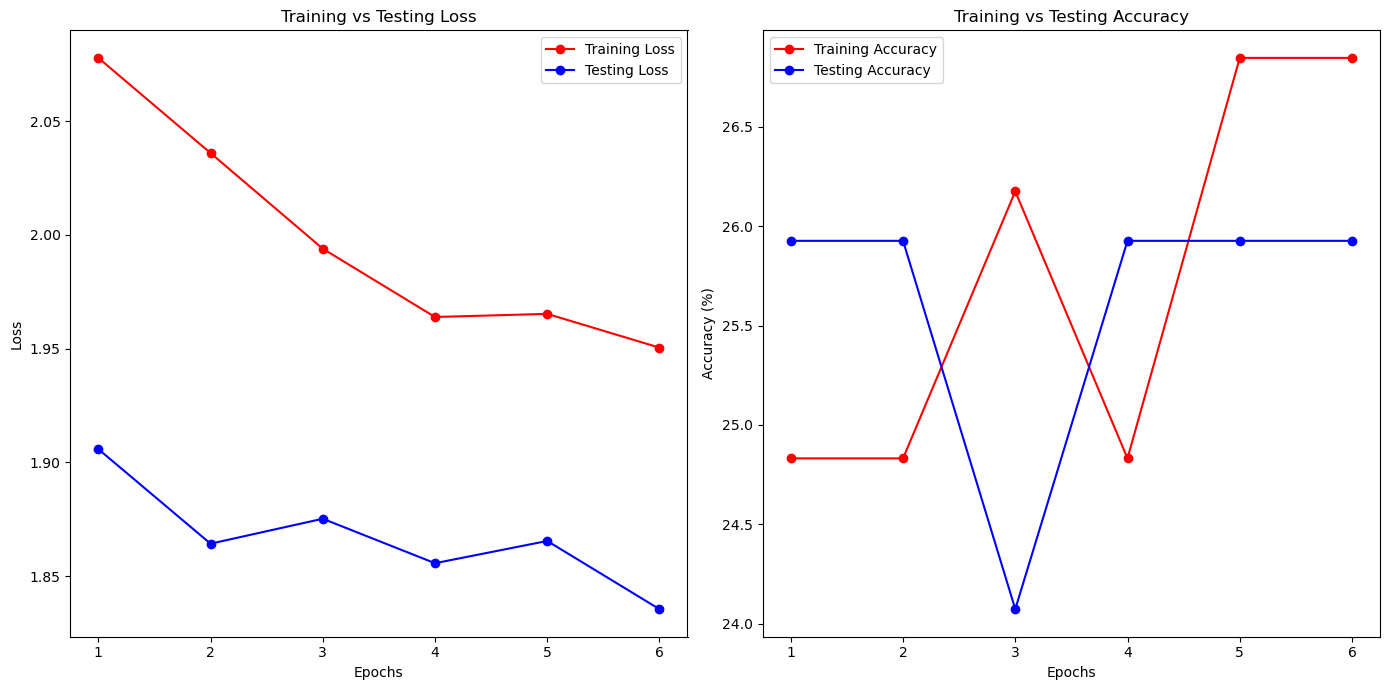

In [ ]:
import matplotlib.pyplot as plt

# Ensure 'epochs' matches the available data length
epochs = range(1, len(train_losses) + 1)

# Plot training and testing loss
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'r-o', label='Training Loss')
plt.plot(epochs, test_losses, 'b-o', label='Testing Loss')
plt.title('Training vs Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and testing accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, 'r-o', label='Training Accuracy')
plt.plot(epochs, test_accuracies, 'b-o', label='Testing Accuracy')
plt.title('Training vs Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()
